In [41]:
## Import necessary libraries 

import os 
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import keras
import datetime as dt
import matplotlib.pyplot as plt 
import urllib.request, json 
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data

### Data Exploration 

In [42]:
df = pd.read_csv("BAC_10.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,2 days,3 days,5 days (1 week)
0,5/24/2010,15.98,16.080000,15.39,15.40,13.759591,170656700,0.000000,0.000000,0.0
1,5/25/2010,14.91,15.540000,14.80,15.49,13.840009,263919800,0.000000,0.000000,0.0
2,5/26/2010,15.91,16.100000,15.38,15.47,13.822140,225933000,0.062549,0.000000,0.0
3,5/27/2010,15.81,16.200001,15.59,16.18,14.456508,163490700,0.616499,0.696917,0.0
4,5/28/2010,16.17,16.180000,15.71,15.74,14.063376,160778500,0.241236,0.223367,0.0


### Data Visualization

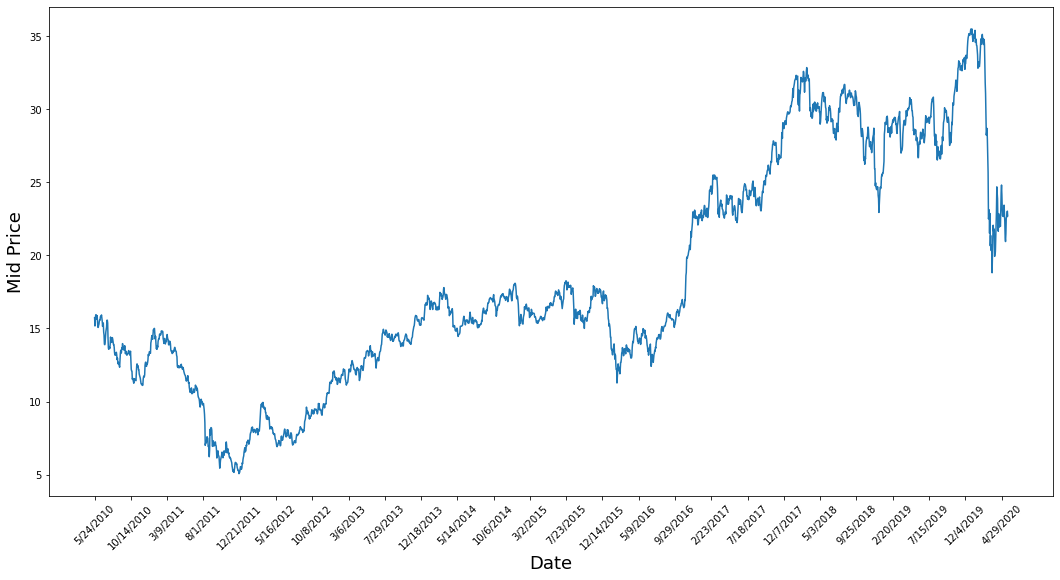

In [43]:
plt.figure(figsize=(18,9))
plt.plot(range(df.shape[0]), (df['Low'] + df['High'])/2.0)

plt.xticks(range(0, df.shape[0],100), df['Date'].loc[::100], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()

### Splitting data into train, test and validation sets

In [44]:
high_prices = df['High']
low_prices = df['Low']

In [45]:
mid_prices = (high_prices + low_prices) / 2.0
print(mid_prices.head())

0    15.735000
1    15.170000
2    15.740000
3    15.895001
4    15.945000
dtype: float64


In [46]:
print(type(mid_prices))

<class 'pandas.core.series.Series'>


In [47]:
len(df)

2518

In [48]:
train_data = mid_prices[:1700].to_numpy()
test_data = mid_prices[1700:].to_numpy()


### Reshaping the data

In [49]:
scaler = MinMaxScaler() # Scale the data between 0 and 1
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [50]:
train_data

array([[15.735    ],
       [15.17     ],
       [15.74     ],
       ...,
       [24.3900005],
       [24.6899995],
       [24.745001 ]])

### Normalizing the data

#### As per the midprice graph above, different periods of stock price data have different range of values. Therefore, we need to smooth the data with a smoothing window so that earlier values in the stock would also add value to the learning process. Taking smoothing window which is considerably of a bigger size as it should not introduce a break at the end of each window.

In [51]:
smoothing_window_size = 500

for i in range(0,1100, smoothing_window_size):
    scaler.fit(train_data[i:i+smoothing_window_size,:])
    train_data[i:i+smoothing_window_size,:] = scaler.transform(train_data[i:i+smoothing_window_size, :])

scaler.fit(train_data[i+smoothing_window_size:, :])
train_data[i+smoothing_window_size:,:] = scaler.transform(train_data[i+smoothing_window_size:, :])


In [52]:
train_data = train_data.reshape(-1)

print(train_data.shape)

(1700,)


In [53]:
test_data = scaler.transform(test_data).reshape(-1)

### Smoothing the data using Exponential moving average on training data

In [54]:
Exp_mov_average = 0.0 
gamma = 0.1 
for t in range(1700):
    # 10% of current value and 90% of older values
    Exp_mov_average = gamma * train_data[t] + (1-gamma) * Exp_mov_average
    train_data[t] = Exp_mov_average

# Data Concat for testing purposes

all_midprice_data = np.concatenate([train_data, test_data], axis=0)

In [57]:
from numpy import savetxt
savetxt('boa_train_data.csv', train_data, delimiter=',')

#### Standard average model which uses 100 days data to predict the future or even exponential moving average which preserves older values will not do well on predicting the stock movement for the next couple of months. 

#### This is the incapability of averaging solutions such as Standard average and exponential moving average

### LSTM 

Cell State (ct) - Internal memory of the cell which stores both short term memory and long-term memories 

Hidden State (ht) - Output state information calculated w.r.t current input, previous hidden state and current cell input which you eventually use to predict future stock market prices. Besides, the hidden state can decide to only retrieve the short or long term or both types of memory stored in the cell state to make the next prediction

Input State (it) - Decides how much information from current input goes to the cell state 

Forget State (ft) - Decides how much information from current input and the previous cell state flows into the current cell state

Output gate (ot) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories. 

### Data Generator 

Data Generator contains 
unroll_batches(...) - outputs a set of num_unrollings batches of input data obtained sequentially, where a batch of data is of size [batch_size, 1]. Each batch of input data will have a corresponding output batch of data

num_unrollings = 3 and batch_size = 4 - 

input data : [x0, x10, x20, x30], [x1, x11, x21, x31], [x2,x12,x22,x32]
output data : [x1, x11,x21,x31], [x2, x12, x22,x13], [x3, x13, x23, x33]

### Data Augmentation 

Assumption - There won't be much break in the stock market for couple of days 

In [56]:
class DataGeneratorSeq(object):
    
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices 
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length // self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
    
    def next_batch(self):
        batch_data = np.zeros((self._batch_size), dtype=np.float32)
        batch_labels = np.zeros((self._batch_size), dtype=np.float32)
        
        for i in range(self._batch_size):
            if self._cursor[i] + 1 >= self._prices_length:
                self._cursor[b] = np.random.randint(0, (i+1)*self._segments)
            batch_data[i] = self._prices[self._cursor[i]]
            batch_labels[i] = self._prices[self._cursor[i]+np.random.randint(0,5)]
            self._cursor[i] = (self._cursor[i]+1) % self._prices_length
        return batch_data, batch_labels
    
    def unroll_batches(self):
        unroll_data, unroll_labels = [], []
        init_data, init_label = None, None
        for i in range(self._num_unroll):
            data, labels = self.next_batch()
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for i in range(self._batch_size):
            self._cursor[i] = np.random.randint(0, min((b+1) * self._segments, self._prices_length - 1))


data_gen = DataGeneratorSeq(train_data, 5, 5)
u_data, u_labels = data_gen.unroll_batches()

for i, (data, label) in enumerate(zip(u_data, u_labels)):
    print("unrolled index")
    data_index = data
    label_index = label
    print("inputs", data)
    print("outputss", label)
    print("\n")

unrolled index
inputs [0.09806897 0.17703165 0.41678512 0.59129673 0.63239163]
outputss [0.09806897 0.17703165 0.4270482  0.6012502  0.63239163]


unrolled index
inputs [0.18113564 0.1736733  0.4179375  0.59752136 0.62963927]
outputss [0.261137   0.16803011 0.4293342  0.60172313 0.630598  ]


unrolled index
inputs [0.261137   0.16803011 0.42076692 0.6009761  0.630598  ]
outputss [0.5099359  0.16803011 0.4293342  0.60172313 0.63525474]


unrolled index
inputs [0.33456355 0.16253746 0.42404866 0.60172313 0.63525474]
outputss [0.5583446  0.13692153 0.4293342  0.60172313 0.63525474]


unrolled index
inputs [0.4011072  0.15681244 0.4270482  0.6012502  0.64173645]
outputss [0.45865163 0.12874661 0.44069788 0.59962493 0.64173645]


